# Analyzing the topic changes and their implications

First, we load the pretrained topic model and the vectors

In [2]:
import numpy as np
from tqdm import tqdm
import sqlite3
import pandas as pd
from collections import defaultdict
from bertopic import BERTopic
from util.sql_switch import get_query_native

#import delab.topic.train_topic_model as tm

bertopic_model = BERTopic().load("BERTopic_en", embedding_model="sentence-transformers/all-mpnet-base-v2")
topic_info = bertopic_model.get_topic_info()


def topic2wordvec(topic_model):
    result = []
    for t_word in topic_model:
        str_w = t_word[0]
        result.append(str_w)
    return result


# create topic-word map
topic2word = defaultdict(list)
for topic_id in tqdm(topic_info.Topic):
    topic_model = bertopic_model.get_topic(topic_id)
    words = topic2wordvec(topic_model)
    topic2word[topic_id] = topic2word[topic_id] + words
t2w_keys = list(topic2word.keys())[0:3]
for key in t2w_keys:
    print(topic2word[key])

100%|██████████| 23/23 [00:00<00:00, 155094.84it/s]

['it', 'is', 'are', 'be', 'they', 'people', 'what', 'your', 'have', 'all']
['covid', 'vaccine', 'vaccinated', 'pandemic', 'vaccines', 'vaccination', 'health', 'virus', 'mask', 'masks']
['uk', 'tory', 'china', 'brexit', 'border', 'eu', 'they', 'mp', 'who', 'politics']


Now we are loading the pre_saved ft vectors from the database!


In [3]:
df_conversations = get_query_native(
    "SELECT id, text, author_id, bertopic_id, conversation_id,sentiment_value,created_at FROM delab_tweet tw where language = 'en' and bertopic_id >= 0")
df_conversations.head(3)

using postgres


,id,text,author_id,bertopic_id,conversation_id,sentiment_value,created_at
0,22884,"@PoliticsJOE_UK Yeah, people like these Iraqis that no doubt would’ve got into dinghies had they got the chance, who are now flying back to Iraq from Belarus because they can’t get into Poland. You know genuine refugees like that🙄 https://t.co/hptkU9skCY",4416209877,4,1464535733058818052,0.5423,2021-11-28 10:30:16+00:00
1,21349,@BernieSpofforth Welcome to Germany!,2793773537,2,1464287786077282304,0.5093,2021-11-26 18:33:29+00:00
2,28092,@ulfposh Lost,986649947243237376,8,1468163142471536644,-0.3182,2021-12-07 10:27:34+00:00


In [4]:
pd.set_option('display.max_colwidth', None)
text = df_conversations.head(1).text
print(text)
id = df_conversations.head(1).bertopic_id[0]
bertopic = bertopic_model.get_topic(id)
print(bertopic)

0    @PoliticsJOE_UK Yeah, people like these Iraqis that no doubt would’ve got into dinghies had they got the chance, who are now flying back to Iraq from Belarus because they can’t get into Poland. You know genuine refugees like that🙄 https://t.co/hptkU9skCY
Name: text, dtype: object
[('he', 0.08909152892451723), ('his', 0.04485406191111942), ('him', 0.029644704516226347), ('guy', 0.025147405502206108), ('himself', 0.01571769148472905), ('respect', 0.014493778043512874), ('chappelle', 0.014070704116319869), ('elon', 0.01347302668047822), ('wife', 0.013009432044783878), ('actor', 0.013009432044783878)]


It looks like our topic is matching the tweet.

In [5]:
df_conversations_bad_topic = get_query_native(
    "SELECT COUNT(*) as n  FROM delab_tweet tw where language = 'en' and bertopic_id < 0")

df_conversations_total = get_query_native(
    "SELECT COUNT(*) as n  FROM delab_tweet tw where language = 'en' and bertopic_id is not null")

print(df_conversations.id.size)
print(df_conversations_bad_topic.n[0])
print(df_conversations_total.n[0])

print("From {} tweets {} percent could not be topic labeled".format(df_conversations_total.n[0],
                                                                    df_conversations_bad_topic.n[0] * 100 /
                                                                    df_conversations_total.n[0]))

using postgres
using postgres
4158
11342
15500
From 15500 tweets 73.1741935483871 percent could not be topic labeled


It seems, that our recall is not so great. We favoured the precision over the recall, drastically removing
topics that did not include words in the vocabulary. However, the bert models have good results on the oov-words, too.

More importantly, the high precision and low recall clashes with low precision and high sensitivity from the sentiment analysis.
However, we are continuing for the moment in order to have a look at the results as they stand.

In [6]:
#df_conversations.conversation_id.nunique()
df_reshaped = df_conversations.pivot(index="id", columns="conversation_id", values="text")
mask = 10 > df_reshaped.nunique()
mask = mask[mask == True]
df_reshaped.drop(columns=mask.index, inplace=True)
df_reshaped.nunique()

conversation_id
1464127502889074691     10
1464236651077640197    359
1464243607313928199     25
1464243804333121542     48
1464287786077282304    274
1464306923013033997     16
1464364597192892416     11
1464484307225878538     33
1464495636628131841     12
1464535733058818052    151
1464637398655111177     95
1464646688426147847    132
1464685325930872835    124
1464753338243633159     56
1464854222436974593     20
1464861156892459011     21
1464881189232250888    248
1466020780190449666     10
1468120339305672704     20
1468163142471536644     14
1468403496781115392     54
1469430090635169793     13
1470688041731866626     18
1471799080422625280    191
1471881656323739650     14
1472028221583601666     78
1472233459108450306    493
1472249457467142146     10
1472321735513026562     14
1472359193294237697    354
1472395673375055875     50
1472398877475196934     11
1472523142908104707     10
1472580223178846215     11
1472678431519297539     74
1472706544017960960     34
147273013516

There are only 4 conversations with 10 or more tweets that have a valid topic classification :-(.

Lets' have a look at the relation between sentiment_values and topic_changes!

In [7]:
conversation_corpora_cleaned = {}
conversation_corpora = df_reshaped.to_dict(orient="series")
for conversation_id, tweets in conversation_corpora.items():
    conversation_corpora_cleaned[conversation_id] = tweets.dropna()

useful_conversations_keys = conversation_corpora_cleaned.keys()

useful_conversations = df_conversations[df_conversations["conversation_id"].isin(useful_conversations_keys)]
useful_conversations = useful_conversations.loc[:,
                       ["id", "bertopic_id", "conversation_id", "sentiment_value", "created_at"]]

example_id = df_reshaped.nunique().index[0]
exampleconversation = useful_conversations[useful_conversations.conversation_id == example_id]
exampleconversation.head(3)

,id,bertopic_id,conversation_id,sentiment_value,created_at
133,21007,12,1464127502889074691,0.0,2021-11-26 16:03:41+00:00
134,21012,12,1464127502889074691,0.0,2021-11-26 11:10:25+00:00
139,21003,12,1464127502889074691,0.0,2021-11-26 21:46:28+00:00


This conversation seems a good candidate for inspection as it includes drastic topic and sentiment changes.


In [8]:
import json
from scipy import spatial
import numpy as np


# in the productive setting filter this query with "in words contained in the current conversation topics"
word2vec = get_query_native(
    "SELECT word, ft_vector from delab_topicdictionary")

def get_topic_delta(topic_id_1, topic_id_2):
    words1 = topic2word.get(topic_id_1)
    words2 = topic2word.get(topic_id_2)
    if words1 is not None and words2 is not None:
        filtered_w2v1 = word2vec[word2vec["word"].isin(words1)]
        filtered_w2v2 = word2vec[word2vec["word"].isin(words2)]
        ft_vectors_1 = filtered_w2v1.ft_vector.apply(lambda x: pd.Series(json.loads(x)))
        ft_vectors_2 = filtered_w2v2.ft_vector.apply(lambda x: pd.Series(json.loads(x)))
        len1 = len(ft_vectors_1)
        len2 = len(ft_vectors_2)
        sum_v1 = (ft_vectors_1.sum(axis=0) / len1) # we assume the vectors are embedded in a linear space
        sum_v2 = (ft_vectors_2.sum(axis=0) / len2)
        similarity = spatial.distance.cosine(sum_v1, sum_v2)
        return similarity
    else:
        return np.NaN

exampleconversation.sort_values(by=['created_at'], ascending=True, inplace=True)
exampleconversation.reset_index(drop=True, inplace=True)
exampleconversation["bertopic_shifted"] = exampleconversation.bertopic_id.shift()
exampleconversation["topic_delta"] = exampleconversation.apply(
    lambda x: get_topic_delta(x.bertopic_id, x.bertopic_shifted), axis=1)

exampleconversation.head(5)

using postgres


,id,bertopic_id,conversation_id,sentiment_value,created_at,bertopic_shifted,topic_delta
0,21022,12,1464127502889074691,0.0000,2021-11-26 07:15:43+00:00,NaN,NaN
1,21019,12,1464127502889074691,0.0772,2021-11-26 08:01:07+00:00,12.0,0.000000
2,21016,12,1464127502889074691,0.0000,2021-11-26 08:26:34+00:00,12.0,0.000000
3,21017,3,1464127502889074691,0.0000,2021-11-26 08:27:29+00:00,12.0,0.826969
4,21012,12,1464127502889074691,0.0000,2021-11-26 11:10:25+00:00,3.0,0.826969


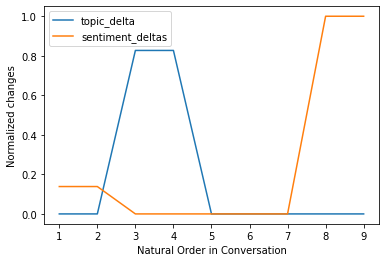

In [9]:
#from sklearn import preprocessing
sv = exampleconversation.sentiment_value
exampleconversation["sentiment_normalized"] = ((sv-sv.min())/(sv.max()-sv.min()))

exampleconversation["sentiment_deltas"] = exampleconversation["sentiment_normalized"].diff().abs()
plot = exampleconversation.plot(y=['topic_delta', "sentiment_deltas"], xlabel = "Natural Order in Conversation", ylabel="Normalized changes", use_index=True)
plot.get_figure().savefig('sentiment_topics.png')

After normalizing, it looks like we can compare the two metrics. However, topic continuation should be
interpreted differently then a continuous sentiment flow.

In order to compute the correlation we need to compute:
- a more precise sentiment classification
- a wider set of conversations with existing topic classifications
- a better metric of the topic flow that takes into account the general frequency of topic  changes and
  can thus highlight conversations with high or low topic volatility